# Habitable Exoplanets -- Research Project 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import habitable_zone_plot as hzp
import random as rng
from collections import Counter

### Trim dataset to only necessary or useful parts

In [2]:
all_exoplanets = pd.read_csv('kepler.csv') # <-- This is the data file
all_exoplanets_drop = all_exoplanets.drop(columns=['angular_distance','orbital_period','eccentricity','inclination','star_distance','star_age','star_metallicity','planet_status','mass','mass_error_min', 'mass_error_max','mass_sini', 'mass_sini_error_min', 'mass_sini_error_max','radius_error_min', 'radius_error_max', 'orbital_period_error_min', 'orbital_period_error_max','semi_major_axis_error_min','semi_major_axis_error_max','eccentricity_error_min','eccentricity_error_max','inclination_error_min','inclination_error_max','omega', 'omega_error_min', 'omega_error_max', 'tperi','tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min','tconj_error_max', 'tzero_tr', 'tzero_tr_error_min','tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min','tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min','lambda_angle_error_max', 'impact_parameter','impact_parameter_error_min', 'impact_parameter_error_max', 'tzero_vr','tzero_vr_error_min', 'tzero_vr_error_max', 'k', 'k_error_min','k_error_max','temp_calculated_error_min','temp_calculated_error_max','hot_point_lon','geometric_albedo', 'geometric_albedo_error_min','geometric_albedo_error_max', 'log_g', 'publication_status','detection_type', 'mass_detection_type', 'radius_detection_type','alternate_names', 'molecules', 'ra', 'dec','mag_v','mag_i', 'mag_j', 'mag_h', 'mag_k','star_distance_error_min', 'star_distance_error_max','star_metallicity_error_min','star_metallicity_error_max','star_mass_error_min','star_mass_error_max','star_radius_error_min','star_radius_error_max','star_age_error_min', 'star_age_error_max', 'star_teff','star_teff_error_min', 'star_teff_error_max', 'star_detected_disc','star_alternate_names', 'temp_calculated', 'temp_measured', 'star_magnetic_field', 'radius', 'discovered', 'updated'])
# ^ Dropping unnecessary columns because they aren't needed to find habitability


#drop rows with missing data & reset the index
exoplanets = all_exoplanets_drop.dropna()
exoplanets = exoplanets.reset_index(drop=True)
exoplanets = exoplanets.rename(columns={'star_sp_type':'spectral_type', '# name': 'planet_name'})

star_types = list(exoplanets['spectral_type'])

#Stripping the general spectral type to simplify the calculation
spectral_types = []
for entry in star_types:
    if entry[0] != ' ':
        spectral_types.append(entry[0].upper())
    else:
        spectral_types.append(entry[1].upper())
        
exoplanets['spectral_type'] = spectral_types

In [3]:
exoplanets

,planet_name,semi_major_axis,star_name,star_mass,star_radius,spectral_type
0,11 Com b,1.2900,11 Com,2.70,19.000,G
1,11 UMi b,1.5400,11 UMi,1.80,24.080,K
2,14 And b,0.8300,14 And,2.20,11.000,K
3,14 Her b,2.7700,14 Her,0.90,0.708,K
4,16 Cyg B b,1.6800,16 Cyg B,1.01,0.980,G
...,...,...,...,...,...,...
869,tau Gem b,1.1700,tau Gem,2.30,26.800,K
870,ups And b,0.0590,ups And,1.27,1.631,F
871,ups And c,0.8610,ups And,1.27,1.631,F
872,ups And d,2.5500,ups And,1.27,1.631,F


### Divide data into its various parts

In [4]:
planet_name = exoplanets['planet_name']
star_name = exoplanets['star_name']
semi_major_axis = exoplanets['semi_major_axis']
star_mass = exoplanets['star_mass']
star_radius = exoplanets['star_radius']
spectral_type = exoplanets['spectral_type']

### Create Exoplanet Object Constructor

In [5]:
class exoplanet(object):
    '''
    This class can be used to turn the data from the dataset into exoplanet objects.
    In order to construct an exoplanet object, you will need the name of the planet,
    the name of the star, the semimajor axis of the planet, the mass of the star,
    the radius of the star, and the star spectral class.
    pl_name: Name of the planet (string)
    st_name: Name of the star (string)
    semi_major: Semimajor axis (in AU)
    st_mass: Mass of the star (in solar masses)
    st_radius: Radius of star (in solar radii)
    st_spectral: Spectral class (string)
    '''
    def __init__(self,pl_name,st_name,semi_major,st_mass,st_radius,st_spectral):
        
        self.pl_name = pl_name
        self.st_name = st_name
        self.semi_major = semi_major
        self.st_mass = st_mass
        self.st_radius = st_radius
        self.st_spectral = st_spectral
        self.st_temp = self.calculate_temp()
        self.st_lum = 4*np.pi*((st_radius*696342000)**2)*5.67e-8*(self.st_temp**4)
        self.habitable_zone = self.find_habitable_zone()
        self.habitability = self.find_habitability()
        
    def calculate_temp(self):
        '''
        Takes the spectal class and finds an estimate of the temperature
        '''
        if self.st_spectral[0] == 'O':
            return 40000
        elif self.st_spectral[0] == 'B':
            return 20000
        elif self.st_spectral[0] == 'A':
            return 8750
        elif self.st_spectral[0] == 'F':
            return 6750
        elif self.st_spectral[0] == 'G':
            return 5500
        elif self.st_spectral[0] == 'K':
            return 4250
        elif self.st_spectral[0] == 'M':
            return 3000
        elif self.st_spectral[0] == 'S':
            return 30000
        elif self.st_spectral[0] == 'W':
            return 40000
        else:
            return 3500
    
    def find_habitable_zone(self):
        scale = np.sqrt(self.st_lum / 3.828e26)
        
        inner = 0.95 * scale
        outer = 1.37 * scale
        
        return (inner,outer)
        
# Below here are all of the get methods that allow us to access the data stored in the object
    def get_pl_name(self):
        return self.pl_name
    
    def get_st_name(self):
        return self.st_name
    
    def get_semi(self):
        return self.semi_major
    
    def get_st_mass(self):
        return self.st_mass
    
    def get_st_radius(self):
        return self.st_radius
    
    def get_st_spectral(self):
        return self.st_spectral
    
    def get_st_lum(self):
        return self.st_lum
    
    def get_st_temp(self):
        return self.st_temp
    
    def get_habitable_zone(self):
        return self.habitable_zone
    
    def find_habitability(self):
        '''
        Takes in the habitable zone and semimajor axis and returns a 1 if it is in the 
        habitable zone, and a zero if not
        '''
        if (self.habitable_zone[0] < self.semi_major) and (self.semi_major < self.habitable_zone[1]):
            return 1
        else:
            return 0
            

### Convert data into exoplanet objects

In [6]:
exoplanet_list = []

for row in exoplanets.iterrows():
    exoplanet_list.append(exoplanet(row[1][0],row[1][2],row[1][1],row[1][3],row[1][4],row[1][5]))

### Creating Arrays For Data Processing

In [7]:
habitable_zone_list=[]

for obj in exoplanet_list:
    habitable_zone_list.append(obj.get_habitable_zone())

In [8]:
semi_major_axis_list=[]

for obj in exoplanet_list:
    semi_major_axis_list.append(obj.get_semi())

In [9]:
habitability_list=[]

for obj in exoplanet_list:
    habitability_list.append(obj.find_habitability())

In [10]:
#Finding the numbers of habitable/uninhabitable planets for later use

habitability_array=np.array(habitability_list)
habitable_number=int(len(np.where(habitability_array==1)[0]))
nonhabitable_number=int(len(np.where(habitability_array==0)[0]))
print(len(np.where(habitability_array==0)[0]), "is the number of uninhabitable exoplanets")
print(len(np.where(habitability_array==1)[0]), "is the number of habitable exoplanets")

823 is the number of uninhabitable exoplanets
51 is the number of habitable exoplanets


### Figures

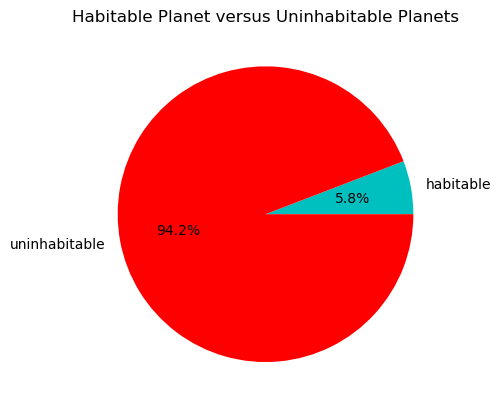

In [11]:
data=[habitable_number,nonhabitable_number]
types=["habitable","uninhabitable"]
color=["c","r"]
plt.title('Habitable Planet versus Uninhabitable Planets')
plt.pie(data,labels=types,autopct='%1.1f%%',colors=color);

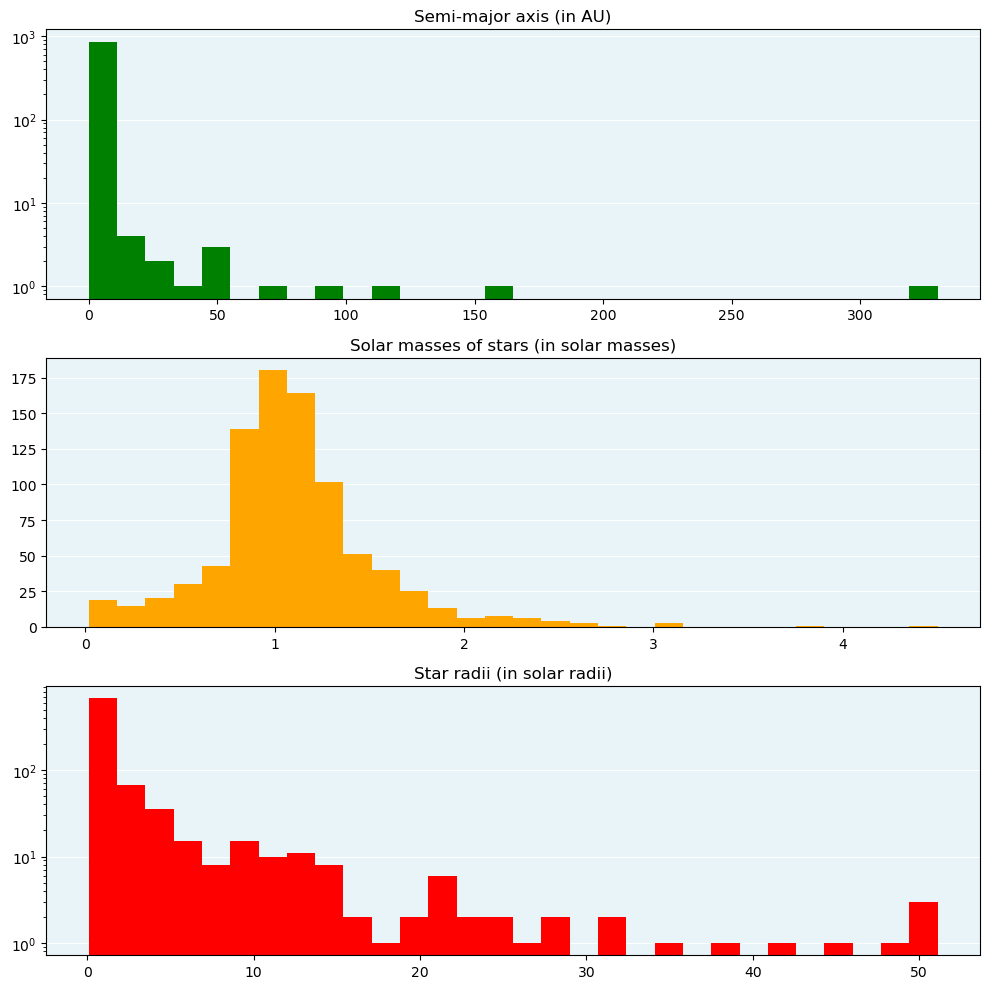

In [12]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

for axis in ax:
    axis.set_facecolor('#e8f4f8')
    axis.set_axisbelow(True)
    axis.yaxis.grid(color='white')

plt.subplot(3,1,1)
plt.hist(semi_major_axis,30,color='green') 
plt.title("Semi-major axis (in AU)")
plt.yscale('log')
plt.subplot(3,1,2)
plt.hist(star_mass,30,color='orange')
plt.title("Solar masses of stars (in solar masses)")
plt.subplot(3,1,3)
plt.hist(star_radius,30,color="red")
plt.title("Star radii (in solar radii)")
plt.yscale('log');

plt.tight_layout()

In [13]:
all_habitable_exoplanets = []

for index in np.where(habitability_array == 1)[0]:
    all_habitable_exoplanets.append(exoplanet_list[index])

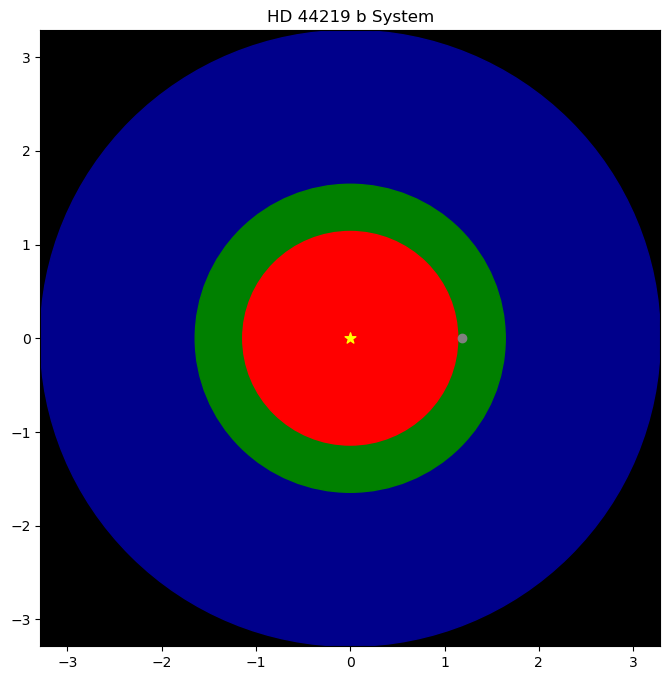

In [14]:
#exo = rng.choice(exoplanet_list) # This block selects a random system
exo = rng.choice(all_habitable_exoplanets) # This block will select a random habitable system

zone = exo.get_habitable_zone()
axis = exo.get_semi()
st_rad = exo.get_st_radius()
st_temp = exo.get_st_temp()
name = exo.get_pl_name()

# Using our plotting script to plot the system and show is the planet is in the habitable zone
fig, ax = hzp.plot_habitability(zone,axis,st_rad,st_temp,name); 


In [17]:
# Creating arrays for following figure
some_sp_types = all_exoplanets_drop['star_sp_type'].dropna()
some_sp_types = list(some_sp_types)

all_spectral_types = []
for entry in some_sp_types:
    if entry[0] != ' ':
        all_spectral_types.append(entry[0].upper())
    else:
        all_spectral_types.append(entry[1].upper())
    
set_all_spectral_types = list(set(all_spectral_types)) # Creating a list of all unique spectral types

# Creating arrays of spectral types, one for number of each spectral type, and one for spectral types of habitable systems
spec_type=[]
spec_type_habitability=[]
for obj in exoplanet_list:
    spec_type.append(obj.get_st_spectral()[0])
for i in range(len(spec_type)):
    if habitability_list[i]==1:
        spec_type_habitability.append(all_spectral_types[i])
    else:
        pass
spec_hab_numbers=Counter(spec_type_habitability)
spec_numbers=Counter(all_spectral_types)

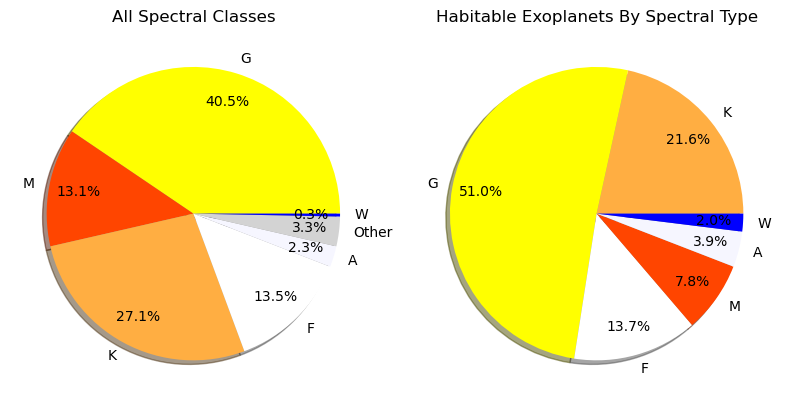

In [38]:
fig ,ax = plt.subplots(1,2,figsize=(8,8))

spec_num=[509,164,340,169,29,41,4]
spec_class=['G','M','K','F','A','Other','W']
colors=["#ffff00","#ff4500","#FFAE42","#FFFFFF","#F6F6FF","lightgray","blue"]
ax[0].set_title('All Spectral Classes')
ax[0].pie(spec_num,labels=spec_class,autopct='%1.1f%%',colors=colors,shadow=True,pctdistance=0.8);

hab_num=[11,26,7,4,2,1]
hab_class=['K',"G",'F',"M","A","W"]
colors = ["#FFAE42","#ffff00","#FFFFFF","#ff4500","#F6F6FF","blue"]
ax[1].set_title('Habitable Exoplanets By Spectral Type')
ax[1].pie(hab_num,labels=hab_class,autopct='%1.1f%%',colors=colors,shadow=True,pctdistance=0.8);

plt.tight_layout()